# SVM——Otto商品分类

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，SVC、SVC + GridSearchCV进行参数调优。

Otto数据集是著名电商Otto提供的一个多类商品分类问题，类别数=9. 每个样本有93维数值型特征（整数，表示某种事件发生的次数，已经进行过脱敏处理）。 竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data


In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

#竞赛的评价指标为logloss
#from sklearn.metrics import log_loss  
#SVM并不能直接输出各类的概率，所以在这个例子中我们用正确率作为模型预测性能的度量
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns
from zhou.utils_zhou import *

%matplotlib inline

## 读取数据 & 数据探索

In [2]:
# 读取数据
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"Otto_train.csv")
train.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [3]:
show_number_describe(train)

共有：[61878]条样本，特征数为：[95]，其中有[94]个特征是number
使用内存大小为: [44.38] KB


,count,mean,std,min,25%,50%,75%,max,dif_vals,dtype,num_null
id,61878,30939.500000,17862.784315,1.0,15470.25,30939.5,46408.75,61878.0,61878,int64,0
feat_1,61878,0.386680,1.525330,0.0,0.00,0.0,0.00,61.0,42,int64,0
feat_2,61878,0.263066,1.252073,0.0,0.00,0.0,0.00,51.0,37,int64,0
feat_3,61878,0.901467,2.934818,0.0,0.00,0.0,0.00,64.0,48,int64,0
feat_4,61878,0.779081,2.788005,0.0,0.00,0.0,0.00,70.0,59,int64,0
feat_5,61878,0.071043,0.438902,0.0,0.00,0.0,0.00,19.0,15,int64,0
feat_6,61878,0.025696,0.215333,0.0,0.00,0.0,0.00,10.0,9,int64,0
feat_7,61878,0.193704,1.030102,0.0,0.00,0.0,0.00,38.0,30,int64,0
feat_8,61878,0.662433,2.255770,0.0,0.00,0.0,1.00,76.0,55,int64,0
feat_9,61878,1.011296,3.474822,0.0,0.00,0.0,0.00,43.0,40,int64,0


In [4]:
## 各属性的统计特性
show_object_describe(train)

共有：[61878]条样本，特征数为：[95]，其中有[1]个特征是object
使用内存大小为: [483.5] KB


,count,unique,top,freq,dif_vals,dtype,num_null
target,61878,9,Class_2,16122,9,object,0


Text(0,0.5,'Number of occurrences')

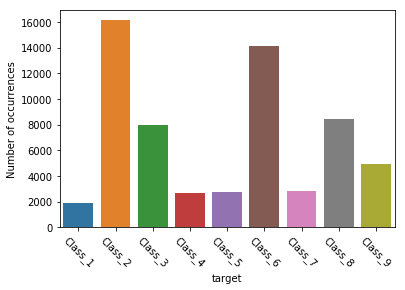

In [5]:
# Target 分布，看看各类样本分布是否均衡
sns.countplot(train.target)
plt.xlabel('target')
plt.xticks(rotation=-45)
plt.ylabel('Number of occurrences')

各类样本不均衡。交叉验证对分类任务缺省的是采用StratifiedKFold，在每折采样时根据各类样本按比例采样

## 特征编码

In [6]:
# 将类别字符串变成数字
# drop ids and get labels
y_train = train['target']   #形式为Class_x
y_train = y_train.map(lambda s: int(s[-1])-1)

X_train = train.drop(["id", "target"], axis=1).values

## 数据预处理

In [7]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 初始化特征的标准化器
ss_X = StandardScaler()

# 分别对训练和测试数据的特征进行标准化处理
X_train = ss_X.fit_transform(X_train)
#X_test = ss_X.transform(X_test)


/home/zhou/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/zhou/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 模型训练

In [8]:
# 训练样本6w+，交叉验证太慢，用train_test_split估计模型性能
from sklearn.model_selection import train_test_split
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, train_size = 0.8,random_state = 0)

/home/zhou/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### default SVC

In [9]:
#LinearSVC不能得到每类的概率，在Otto数据集要求输出每类的概率，这里只是示意SVM的使用方法
#https://xacecask2.gitbooks.io/scikit-learn-user-guide-chinese-version/content/sec1.4.html
#1.4.1.2. 得分与概率
from sklearn.svm import LinearSVC

SVC1 = LinearSVC().fit(X_train_part, y_train_part)

In [10]:
#在校验集上测试，估计模型性能
from sklearn import metrics
y_predict = SVC1.predict(X_val)

print("Classification report for classifier %s:\n%s\n"
      % (SVC1, metrics.classification_report(y_val, y_predict)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_val, y_predict))

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):
             precision    recall  f1-score   support

          0       0.65      0.21      0.32       370
          1       0.61      0.90      0.72      3205
          2       0.52      0.25      0.34      1546
          3       0.80      0.12      0.21       566
          4       0.96      0.94      0.95       542
          5       0.91      0.93      0.92      2823
          6       0.72      0.53      0.61       572
          7       0.85      0.90      0.88      1703
          8       0.85      0.83      0.84      1049

avg / total       0.75      0.75      0.72     12376


Confusion matrix:
[[  78   51    1    0    1   43    9   89   98]
 [   1 2886  265    6    8   12   16    9    2]
 [   0 1100  394    4    2    4   32    7    3

### 线性SVM正则参数调优

线性SVM LinearSVC的需要调整正则超参数包括C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和正则函数penalty（L2/L1） 

采用交叉验证，网格搜索步骤与Logistic回归正则参数处理类似，在此略。

这里我们用校验集（X_val、y_val）来估计模型性能

In [11]:
def fit_grid_point_Linear(C, X_train, y_train, X_val, y_val):
    
    # 在训练集是那个利用SVC训练
    SVC2 =  LinearSVC( C = C)
    SVC2 = SVC2.fit(X_train, y_train)
    
    # 在校验集上返回accuracy
    accuracy = SVC2.score(X_val, y_val)
    
    print("accuracy: {}".format(accuracy))
    return accuracy

In [12]:
#需要调优的参数
C_s = np.logspace(-3, 3, 7)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份  
#penalty_s = ['l1','l2']

accuracy_s = []
for i, oneC in enumerate(C_s):
#    for j, penalty in enumerate(penalty_s):
    tmp = fit_grid_point_Linear(oneC, X_train, y_train, X_val, y_val)
    accuracy_s.append(tmp)


accuracy: 0.7377989657401423
accuracy: 0.7458791208791209
accuracy: 0.7478991596638656
accuracy: 0.7493535875888817
accuracy: 0.7463639301874596
accuracy: 0.677682611506141
accuracy: 0.6101325145442793


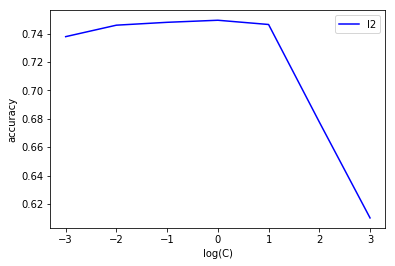

In [13]:
x_axis = np.log10(C_s)
#for j, penalty in enumerate(penalty_s):
plt.plot(x_axis, np.array(accuracy_s), 'b-', label='l2')
    
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'accuracy' )
plt.legend()
#plt.savefig('SVM_Otto.png' )

plt.show()


### RBF核SVM正则参数调优

RBF核是SVM最常用的核函数。
RBF核SVM 的需要调整正则超参数包括C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和核函数的宽度gamma
C越小，决策边界越平滑； 
gamma越小，决策边界越平滑。

采用交叉验证，网格搜索步骤与Logistic回归正则参数处理类似，在此略。

这里我们用校验集（X_val、y_val）来估计模型性能

In [14]:
from sklearn.svm import SVC

In [15]:
def fit_grid_point_RBF(C, gamma, X_train, y_train, X_val, y_val):
    
    # 在训练集是那个利用SVC训练
    SVC3 =  SVC( C = C, kernel='rbf', gamma = gamma)
    SVC3 = SVC3.fit(X_train, y_train)
    
    # 在校验集上返回accuracy
    accuracy = SVC3.score(X_val, y_val)
    
    print("accuracy: {0}".format(accuracy))
    return accuracy

In [ ]:
#需要调优的参数
C_s = np.logspace(-2, 2, 5)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份 
gamma_s = np.logspace(-2, 2, 5)  

accuracy_s = []
for i, oneC in enumerate(C_s):
    for j, gamma in enumerate(gamma_s):
        tmp = fit_grid_point_RBF(oneC, gamma, X_train, y_train, X_val, y_val)
        accuracy_s.append(tmp)


accuracy: 0.6769553975436329
accuracy: 0.4462669683257919
accuracy: 0.2633322559793148


从上述部分运行结果来看，gamma参数设置不合适（gamma越大，对应RBF核的sigma越小，决策边界更复杂，可能发生了过拟合）
所以调小gamma值

In [ ]:
#需要调优的参数
C_s = np.logspace(-1, 2, 4)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份 
gamma_s = np.logspace(-5, -2, 4)  

accuracy_s = []
for i, oneC in enumerate(C_s):
    for j, gamma in enumerate(gamma_s):
        tmp = fit_grid_point_RBF(oneC, gamma, X_train, y_train, X_val, y_val)
        accuracy_s.append(tmp)

In [ ]:
accuracy_s1 =np.array(accuracy_s).reshape(len(C_s),len(gamma_s))
x_axis = np.log10(C_s)
for j, gamma in enumerate(gamma_s):
    plt.plot(x_axis, np.array(accuracy_s1[:,j]), label = ' Test - log(gamma)' + str(np.log10(gamma)))


plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'accuracy' )
plt.legend()
#plt.savefig('RBF_SVM_Otto.png' )

plt.show()